# Topic Modeling and Data Visualiztion in NLP 

**Author**: Andres Talero

In this notebook, we perform some analysis on a Kaggle news dataset (https://www.kaggle.com/rmisra/news-category-dataset). We produce N-Grams, some visualizatoins, and lastly use LDA for topic modeling.

Library imports to be used throughout this document

In [1]:
import json, re, xlsxwriter
import pandas as pd

import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import defaultdict

In [56]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10

In [2]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/andres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

NLTK Stemmer for data preprocessing in Part 2

In [3]:
stemmer = SnowballStemmer("english")

File name of News Category Dataset (located in same directory)

In [4]:
file_name = "./News_Category_Dataset_v2.json"

## Part I: Producing N-Gram Models
We demonstrate how we produce all bigram and unigram counts and output the .xlsx file. Part 1 can be found as part_1.py in accompanying attachments.

First, we produce defaultdicts where we will store our word counts.

In [ ]:
unigram_counts_dict = defaultdict(int)
bigram_counts_dict = defaultdict(int)

preprocessed_counts is for later use in Part 2

In [9]:
preprocessed_counts = defaultdict(int)  

In [10]:
unigram_text = []

START and STOP tokens are useful because they allow us to produce a language model using n-grams with n greater than 1. For this problem, I have made the design choice that every "headline" and "short description" begins with a START token and ends with STOP token. e.g. If a "short description" starts with "The", then "\_START\_ The" would count as a bigram.

Similarly, if a "short description" ends with New York, then "York \_STOP\_ would also count as a bigram".

In [8]:
START_TOKEN = "_START_"
STOP_TOKEN = "_STOP_"

This function stores word counts in the dictionaries created above, the "preprocessed" option is for calls to this function in **Part 2**. We make the decision to count puntuation as words.

In [11]:
def produce_counts(line, preprocessed = False):
    #regular expression to add a space between punctuation marks and any words following or preceeding them
    line = re.sub('(\s\')|(\'\s)', ' ', line)
    line = re.sub('([.,!?\(\)\[\]\";:])', r' \1 ', line)
    line = re.sub('  ', ' ', line)
    
    #add the start and end tokens to any short description or headline
    line = START_TOKEN + " " +  line + " " +  STOP_TOKEN
    
    line = line.split(" ")
    
    for i in range(1,len(line)):
        if not preprocessed:
            if line[i] != STOP_TOKEN:
                unigram_text.append(line[i])        
            unigram_counts_dict[line[i]] += 1
            bigram_counts_dict[line[i-1] + " " + line[i]] +=1
        else:
            preprocessed_counts[line[i]] += 1

The followinrg function reads data from original file and calls produce_counts() to add data to dictionaries

In [12]:
def read_data():
    with open(file_name,"r") as read_file:
        for line in read_file.readlines():
            line = json.loads(line)
            produce_counts(line["short_description"])
            produce_counts(line["headline"])

    #DELETE STOP from dict
    del unigram_counts_dict[STOP_TOKEN]

Writes excel file using the counts generated in the dictionaries

In [13]:
def produce_excel():
    workbook = xlsxwriter.Workbook('counts.xlsx')

    worksheet = workbook.add_worksheet()
    row = 0
    col = 0

    for word in unigram_counts_dict:
        worksheet.write(row, col,     word)
        worksheet.write(row, col + 1, unigram_counts_dict[word])
        row += 1

    worksheet2 = workbook.add_worksheet()
    row = 0
    col = 0

    for bigram in bigram_counts_dict:
        worksheet2.write(row, col,     bigram)
        worksheet2.write(row, col + 1, bigram_counts_dict[bigram])
        row += 1

    workbook.close()

In [14]:
read_data()
produce_excel()

View the counts.xlsx file located in the current directory for results.

## Part 2: NLP Analysis

### Word Preprocessing Functions for NLP Analysis
These functions will be used in our analyses for Part 2

In [15]:
#performs lemmatization (words in third person are changed to first person)
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

#remove stop words and all words with length greater than 3 and stem the words
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

### Word Cloud
We will make a word cloud with words that thave been tokenized, lematized, and stemmed using functions above. Additionally, all stop words are removed.

First we perform some preprocessing.

In [16]:
unigram_string = " ".join(unigram_text)

In [17]:
processed_unigram_string = preprocess(unigram_string)

Now we generate a string containing all short descriptions and headlines concatenated as one single string.

In [18]:
processed_unigram_string = " ".join(processed_unigram_string)

We produce our word cloud using the wordcloud library

In [19]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords= None, ).generate(processed_unigram_string)

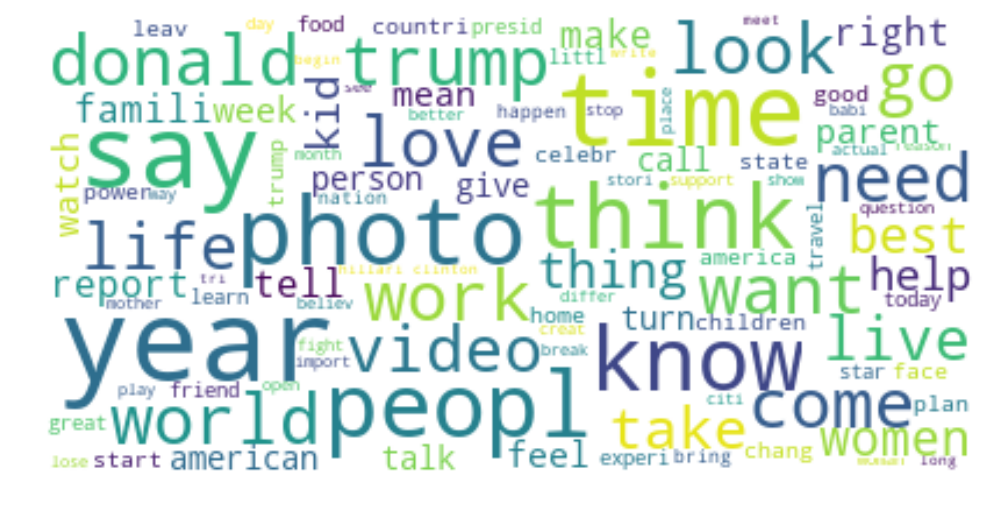

In [20]:
plt.figure(figsize=(12, 8), dpi=100)
#figure(num=None, , dpi=80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Histogram - Counts of 50 Most Frequent (preprocessed) words

For our histogram, we need to again perform some preprocessing to get the counts. Again, we want to use only words that have been run through our preprocessing functions. First, we use out produce_counts function from **Part 1**.

In this case, produce_counts is used to generate word counts for preprocessed words.

In [23]:
produce_counts(processed_unigram_string, preprocessed = True)

We produce a list of tuples (counts_list)

In [51]:
counts_list = []
for element in preprocessed_counts:
    counts_list.append((preprocessed_counts[element],element))

A sample of what counts_list looks like

In [58]:
counts_list[0:15]

[(36692, 'trump'),
 (33302, 'year'),
 (29410, 'time'),
 (28616, 'photo'),
 (28434, 'say'),
 (26990, 'like'),
 (24654, 'peopl'),
 (21938, 'know'),
 (20460, 'want'),
 (19216, 'life'),
 (18308, 'look'),
 (18180, 'world'),
 (17934, 'love'),
 (17672, 'need'),
 (17280, 'week')]

In [52]:
counts_list.sort(reverse=True)

Keep only the 50 most frequent words

In [53]:
counts_list = counts_list[0:50]

Create two np arrays which we use to produce our final histogram

In [54]:
word_list = []
counter = []
for word in counts_list:
    word_list.append(word[1])
    counter.append(word[0])

labels = np.array(word_list)
values = np.array(counter)

Produce the histogram

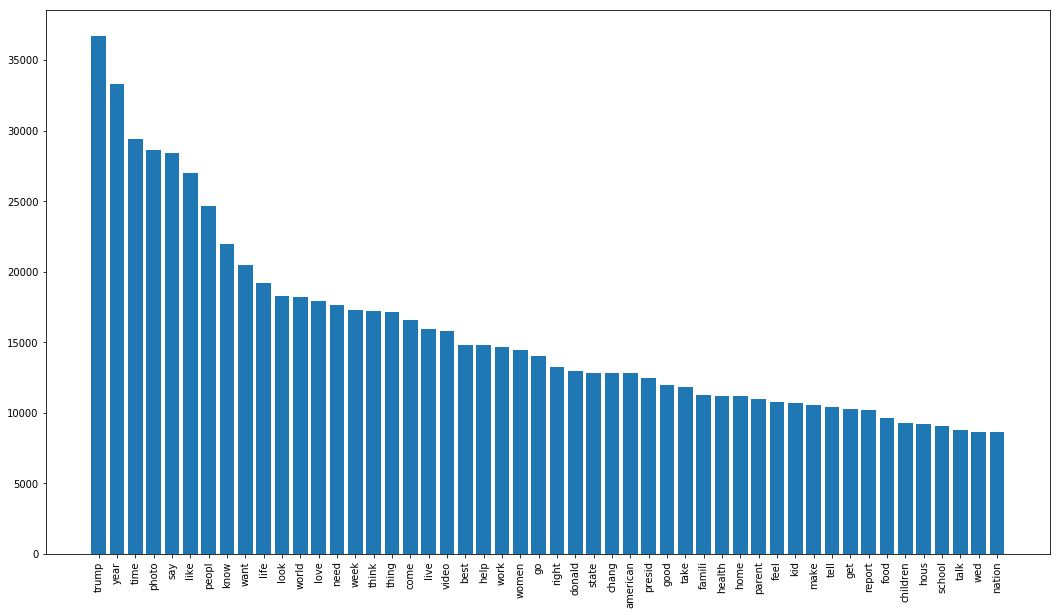

In [59]:
plt.bar(labels, values)
plt.xticks(labels, rotation=90)
plt.show()

### LDA
Now, we will run LDA on our data

**Data Preprocessing**

Let a document be a body composed of the short description appended (with a space in between) to the headline. First, we combine the headline and short description for each JSON object

In [60]:
LDA_data = []

with open(file_name,"r") as read_file:
    for line in read_file.readlines():
        line = json.loads(line)
        LDA_data.append(line["short_description"] + " " + line["headline"])        

Example of joined short_description and headline:

In [61]:
LDA_data[5]

'"It is not right to equate horrific incidents of sexual assault with misplaced compliments or humor," he said in a statement. Morgan Freeman \'Devastated\' That Sexual Harassment Claims Could Undermine Legacy'

After preprocessing using our preprocessing functions above, we get entries such as the following:

In [64]:
preprocess(LDA_data[5])

['right',
 'equat',
 'horrif',
 'incid',
 'sexual',
 'assault',
 'misplac',
 'compliment',
 'humor',
 'say',
 'statement',
 'morgan',
 'freeman',
 'devast',
 'sexual',
 'harass',
 'claim',
 'undermin',
 'legaci']

Create a Pandas Dataframe from the LDA_data

In [65]:
data_df = pd.DataFrame({'text':LDA_data})
data_df[:10]

,text
0,She left her husband. He killed their children...
1,Of course it has a song. Will Smith Joins Dipl...
2,The actor and his longtime girlfriend Anna Ebe...
3,The actor gives Dems an ass-kicking for not fi...
4,"The ""Dietland"" actress said using the bags is ..."
5,"""It is not right to equate horrific incidents ..."
6,"It's catchy, all right. Donald Trump Is Lovin'..."
7,There's a great mini-series joining this week....
8,"Myer's kids may be pushing for a new ""Powers"" ..."
9,You're getting a recent Academy Award-winning ...


Preprocess the whole data frame

In [66]:
processed = data_df['text'].map(preprocess)

Sample data after preprocessing

In [67]:
processed[:10]

0    [leav, husband, kill, children, america, mass,...
1    [cours, song, smith, join, diplo, nicki, world...
2    [actor, longtim, girlfriend, anna, eberstein, ...
3    [actor, give, dem, kick, fight, hard, donald, ...
4    [dietland, actress, say, bag, cathart, therape...
5    [right, equat, horrif, incid, sexual, assault,...
6    [catchi, right, donald, trump, lovin, mcdonald...
7    [great, mini, seri, join, week, watch, amazon,...
8    [myer, kid, push, power, film, mike, myer, rev...
9    [get, recent, academi, award, win, movi, watch...
Name: text, dtype: object

As per the documentation for Dictionary(ies) in NLTK, 'Dictionary encapsulates the mapping between normalized words and their integer ids.

In [68]:
dictionary = gensim.corpora.Dictionary(processed)

Keep tokens in less than 15 docs, more than 0.5 docs, and then keep 100,000 most frequent tokens after the latter two tranformations. 

In [69]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

Transform to Bag of Words (bow)

In [70]:
bow = [dictionary.doc2bow(doc) for doc in processed]

The first entry of a tuple in bow is a word id, the second entry is count for that word, for example:

In [71]:
bow[4]

[(34, 1),
 (40, 1),
 (41, 1),
 (42, 2),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1)]

Run LDA!

passes is the number of passes over training data, workers is # of cpu cores to be used, id2word is our mapping from id's to words, the other params are intuitive.

In [72]:
lda_model = gensim.models.LdaMulticore(bow, num_topics=15, id2word=dictionary, passes=2, workers=2)

Print our 15 Topics

In [74]:
#Printing the 15 topics created using LDA
for i in range(0, lda_model.num_topics):
    print ("Topic " + str(i)  + "\n" + lda_model.print_topic(i) + "\n")

Topic 0
0.020*"state" + 0.015*"american" + 0.012*"chang" + 0.010*"percent" + 0.010*"nation" + 0.009*"countri" + 0.008*"unit" + 0.008*"million" + 0.007*"america" + 0.007*"year"

Topic 1
0.022*"diet" + 0.020*"morn" + 0.011*"email" + 0.011*"glass" + 0.010*"clinton" + 0.007*"bottl" + 0.007*"hillari" + 0.007*"stewart" + 0.007*"flower" + 0.007*"anxieti"

Topic 2
0.033*"health" + 0.033*"studi" + 0.018*"cancer" + 0.016*"care" + 0.016*"research" + 0.015*"sleep" + 0.012*"risk" + 0.010*"peopl" + 0.010*"diseas" + 0.009*"patient"

Topic 3
0.013*"dress" + 0.013*"film" + 0.012*"design" + 0.012*"movi" + 0.010*"wear" + 0.009*"collect" + 0.009*"brain" + 0.008*"best" + 0.007*"look" + 0.007*"like"

Topic 4
0.090*"photo" + 0.028*"style" + 0.022*"check" + 0.021*"week" + 0.018*"look" + 0.018*"fashion" + 0.017*"video" + 0.015*"facebook" + 0.012*"hotel" + 0.011*"twitter"

Topic 5
0.023*"food" + 0.014*"way" + 0.011*"recip" + 0.011*"healthi" + 0.010*"stress" + 0.010*"like" + 0.009*"good" + 0.009*"thing" + 0.009*

**LDA Results**

We observe 15 topics and the words (including their weights) that produce each one. It is easy to find a general theme in most of these; for example, topic 13 is clealy about sports and athletics.


The text variable in the codeblock below is the concatenated headline and short description from an article taken from Reuters (https://www.reuters.com/article/us-sweden-ebola/tests-show-suspected-swedish-ebola-patient-not-infected-idUSKCN1OY12U)

In [87]:
text = "Tests show suspected Swedish Ebola patient not infected' Medical tests have shown a patient treated in isolation at Sweden's Uppsala University Hospital for suspected Ebola is not infected with the virus after all, authorities said on Friday."

bow = dictionary.doc2bow(preprocess(text))

We see what score out LDA model assigns to the article for each of the 15 topice printed above.

In [89]:
for i, s in sorted(lda_model[bow]):
    print("score: {}\n Topic: {}\n\n".format(s, lda_model.print_topic(i, 8)))

score: 0.5164284706115723
 Topic: 0.033*"health" + 0.033*"studi" + 0.018*"cancer" + 0.016*"care" + 0.016*"research" + 0.015*"sleep" + 0.012*"risk" + 0.010*"peopl"


score: 0.04810807853937149
 Topic: 0.090*"photo" + 0.028*"style" + 0.022*"check" + 0.021*"week" + 0.018*"look" + 0.018*"fashion" + 0.017*"video" + 0.015*"facebook"


score: 0.0635206326842308
 Topic: 0.023*"food" + 0.014*"way" + 0.011*"recip" + 0.011*"healthi" + 0.010*"stress" + 0.010*"like" + 0.009*"good" + 0.009*"thing"


score: 0.04957281053066254
 Topic: 0.014*"love" + 0.013*"women" + 0.012*"babi" + 0.011*"life" + 0.010*"girl" + 0.009*"parent" + 0.009*"like" + 0.009*"mother"


score: 0.29338449239730835
 Topic: 0.026*"school" + 0.014*"student" + 0.012*"colleg" + 0.011*"report" + 0.010*"year" + 0.009*"offic" + 0.009*"shoot" + 0.008*"south"




In this article about healthcare, the highest score (score = 0.5164284706115723) goes to a topic which is clearly about health issues. Although this is not proper test for a machine learning algorithm, we still observe that for this particular article we get reasonable results.

### Expanding on LDA - Topics by Author
Note that in the previous exercise with LDA, we  create a bag of words over all headlines and short descriptions. Now, we want to treat all the headlines and short descriptions for each **author** as a corpus of its own i.e. one bag of words per author, such that we can explore the top three topics for each author. 

First we must perform some data exploration.



In [91]:
df2 = pd.read_json(file_name, lines=True)

In [92]:
df2.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


We create out own dictionary with a mapping as follows:

author: {text, counts}

where text is the aggregated headline and short description over all articles written by the same author, and count is the number of articles that author has written.

In [93]:
author_text_dict = {}

with open(file_name,"r") as read_file:
    for line in read_file.readlines():
        line = json.loads(line)
        author = line["authors"]
                
        text = preprocess(line["short_description"] + line["headline"])
        
        if author not in author_text_dict.keys():
            author_text_dict[author] = {"text": [text], "count":1}
        else:
            author_text_dict[author]["text"].append(text)
            author_text_dict[author]["count"] += 1

This is an example of an entry for an author_text_dict

In [94]:
author_text_dict["Ron Dicker"]

{'text': [['actor',
   'longtim',
   'girlfriend',
   'anna',
   'eberstein',
   'tie',
   'knot',
   'civil',
   'ceremoni',
   'hugh',
   'grant',
   'marri',
   'time'],
  ['actor',
   'give',
   'dem',
   'kick',
   'fight',
   'hard',
   'donald',
   'trump',
   'carrey',
   'blast',
   'castrato',
   'adam',
   'schiff',
   'democrat',
   'artwork'],
  ['dietland',
   'actress',
   'say',
   'bag',
   'cathart',
   'therapeut',
   'moment',
   'julianna',
   'marguli',
   'use',
   'donald',
   'trump',
   'poop',
   'bag',
   'pick'],
  ['right',
   'equat',
   'horrif',
   'incid',
   'sexual',
   'assault',
   'misplac',
   'compliment',
   'humor',
   'say',
   'statement',
   'morgan',
   'freeman',
   'devast',
   'sexual',
   'harass',
   'claim',
   'undermin',
   'legaci'],
  ['catchi',
   'right',
   'donald',
   'trump',
   'lovin',
   'mcdonald',
   'jingl',
   'tonight'],
  ['go',
   'token',
   'appreci',
   'seth',
   'meyer',
   'funni',
   'regret',
   'trump',
 

Now we would like to observe what our data looks like in terms of counts for number of articles written per author.

In [95]:
df3 = df2.groupby("authors").agg(['count'])

In [96]:
df3

,category,date,headline,link,short_description
,count,count,count,count,count
authors,,,,,
,36620,36620,36620,36620,36620
"Basil Kreimendahl, Contributor\nPlaywright",1,1,1,1,1
"Bill Bigelow, ContributorRethinking Schools curriculum editor, Zinn Education Project c...",1,1,1,1,1
"Bustle, Contributor\nNews, entertainment, lifestyle site",2,2,2,2,2
"Bustle, ContributorNews, entertainment, lifestyle site",1,1,1,1,1
"Cristian Farias, Elise Foley, and Willa Frej",1,1,1,1,1
"Jamie Walker, ContributorCEO and Founder of SweatGuru & Fit Approach",4,4,4,4,4
"Josh Horwitz, ContributorExecutive Director, Coalition to Stop Gun Violence",2,2,2,2,2


We observe that a lot of authors only have 1 article attribbuted to them, we would like to keep only authors with a significant number of articles. We (somewhat arbitrarily) choose 100, under the assumption that 100 articles will generate enough data to perform LDA topic modelling for an author.

In [99]:
df4 = df3.loc[df3[('category', 'count')] >= 100]

df4 contains all the authors who have produced at least 100 articles from out dataset.

In [100]:
df4

,category,date,headline,link,short_description
,count,count,count,count,count
authors,,,,,
,36620,36620,36620,36620,36620
Abigail Williams,180,180,180,180,180
Akbar Shahid Ahmed,152,152,152,152,152
Alana Horowitz Satlin,360,360,360,360,360
Alanna Vagianos,607,607,607,607,607
Alena Hall,104,104,104,104,104
Alexander C. Kaufman,385,385,385,385,385
Alison Spiegel,168,168,168,168,168


We generate a new dictionary (new_dict) which contains an object of the LDA model run all of the articles by each author, such that we have three topics per author. The code below is very similar to that explained previously, except that now we run LDA for each author.

filter_extremes was altered to reduce filtering (we retain more data), given that for each author we have significantly less data to work with than when we produced a single bag of words over on all data.

In [103]:
new_dict = {}
count = 0

MIN_ARTICLES = 100

for element in author_text_dict:
    if author_text_dict[element]["count"] >= MIN_ARTICLES:
        #create entry in new_dict only if count suffices
        new_dict[element] = author_text_dict[element]
        
        #add a gensim dictionary (takes iter of iter of strings) and filter
        dictionary =  gensim.corpora.Dictionary(new_dict[element]["text"])
        dictionary.filter_extremes(no_above=0.5, keep_n=100000)
        
        #create bag of words based on corpus
        bow = [dictionary.doc2bow(doc) for doc in new_dict[element]["text"]]
        
        try:
            lda = gensim.models.LdaMulticore(bow, num_topics = 3, id2word=dictionary, passes=2, workers=2)
        except:
            lda = 'No results'
        
        new_dict[element]["lda"] = lda
        
        count +=1
        
        #Ucomment this line to view progress when running this cell
        #print("completed " + str(count) + " entries")

print_topics below simply prints any topic for any author that is input into the function call. Any author from data frame df4 (authors with at least 100 artciles) can be input into this cell.

In [104]:
def print_topics(author):

    try:
        lda_model = new_dict[author]["lda"]
    except:
        print ("no such author exists")
    
    try:
        num_topics = lda_model.num_topics
    except:
        print("LDA could not be run for this author")
        return
    
    for i in range(0, lda_model.num_topics):
        print ("Topic " + str(i)  + "\n" + lda_model.print_topic(i) + "\n")

We show a few examples of what print_topics returns for several authors.

In [105]:
print_topics("Tyler Kingkade")

Topic 0
0.091*"student" + 0.073*"univers" + 0.049*"assault" + 0.046*"sexual" + 0.034*"professor" + 0.023*"grad" + 0.020*"accus" + 0.020*"year" + 0.018*"campus" + 0.018*"school"

Topic 1
0.073*"sexual" + 0.059*"assault" + 0.048*"colleg" + 0.040*"campus" + 0.039*"rape" + 0.030*"school" + 0.029*"say" + 0.029*"student" + 0.028*"group" + 0.027*"case"

Topic 2
0.146*"colleg" + 0.081*"student" + 0.050*"campus" + 0.027*"presid" + 0.025*"univers" + 0.023*"frat" + 0.021*"report" + 0.020*"school" + 0.019*"rape" + 0.019*"issu"



In [106]:
print_topics("Andy McDonald")

Topic 0
0.030*"trump" + 0.020*"like" + 0.017*"want" + 0.014*"year" + 0.014*"play" + 0.013*"peopl" + 0.012*"donald" + 0.011*"game" + 0.011*"look" + 0.011*"star"

Topic 1
0.069*"trump" + 0.023*"colbert" + 0.022*"donald" + 0.018*"presid" + 0.017*"peopl" + 0.016*"like" + 0.015*"know" + 0.013*"stephen" + 0.011*"thing" + 0.011*"come"

Topic 2
0.019*"twitter" + 0.015*"black" + 0.012*"best" + 0.012*"go" + 0.012*"real" + 0.012*"time" + 0.012*"world" + 0.011*"like" + 0.010*"say" + 0.010*"movi"



In [107]:
print_topics("Suzy Strutner")

Topic 0
0.026*"place" + 0.018*"airport" + 0.017*"actual" + 0.017*"flight" + 0.016*"like" + 0.016*"trip" + 0.014*"town" + 0.014*"free" + 0.013*"hotel" + 0.013*"night"

Topic 1
0.032*"world" + 0.020*"look" + 0.019*"flight" + 0.018*"travel" + 0.016*"beach" + 0.016*"year" + 0.015*"offer" + 0.015*"vacat" + 0.015*"best" + 0.015*"photo"

Topic 2
0.056*"travel" + 0.018*"thing" + 0.016*"know" + 0.015*"island" + 0.015*"airlin" + 0.015*"like" + 0.013*"citi" + 0.012*"world" + 0.011*"time" + 0.011*"food"



In [108]:
print_topics("Taylor Pittman")

Topic 0
0.030*"parent" + 0.029*"kid" + 0.027*"say" + 0.024*"women" + 0.017*"mom" + 0.016*"photo" + 0.016*"girl" + 0.014*"ask" + 0.013*"woman" + 0.013*"pregnanc"

Topic 1
0.038*"time" + 0.033*"kid" + 0.030*"babi" + 0.029*"like" + 0.022*"parent" + 0.021*"star" + 0.020*"famili" + 0.020*"love" + 0.018*"give" + 0.017*"video"

Topic 2
0.047*"year" + 0.035*"kid" + 0.024*"watch" + 0.024*"want" + 0.022*"parent" + 0.017*"say" + 0.017*"girl" + 0.015*"need" + 0.015*"go" + 0.014*"daughter"



We definitely see an overarching theme for each of these authors, it is obvious that Taylor Pittman writes about parenting and family. If we look at her twitter tagline, it says "Taylor Pittman is a culture and parenting reporter for HuffPost". However, it is more diffifult to distinguish between the thematic of individual topics for each author.

**Possible Improvements and Extensions**

We can expand the application of our generative model to predict, for some article in test data, which author's writing it fits the best. This code could be added in a similar way to how we introduced an unseen article to the first LDA model in the notebook, and retrieved scores for each topic. 

### References

(2018). Topic Modeling and Latent Dirichlet Allocation (LDA) in Python. [online] Towards Data Science. Available at: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24 [Accessed 4 Jan. 2019].